**NOTE**: This notebook implements the class defined in `models/reranker_sentiment.py`, and is intended for testing and exploration of the post-hoc sentiment-aware extension to KeyBERT.

# KeyBERT with Post-hoc Sentiment-aware Re-ranking

This extension enhances the original KeyBERT framework by adjusting the ranking of candidate keywords based not only on semantic similarity, but also on their emotional alignment with the input document.

*The goal is to favour keywords that are both semantically relevant and sentimentally aligned with the overall tone of the review.*

### Theoretical Framework

The original KeyBERT keyword generation is preserved. The modification occurs **after candidate selection**, during the **re-ranking phase**.

Given:
- `cos_sim`: the cosine similarity between a candidate keyword and the document,
- `s_doc ∈ [0, 1]`: the normalized sentiment polarity of the document,
- `s_kw ∈ [0, 1]`: the normalized sentiment polarity of the candidate keyword,

we compute a sentiment alignment score as:

$$
\text{align}(s_{doc}, s_{kw}) = 1 - |s_{doc} - s_{kw}|
$$

To improve comparability with cosine similarity (which ranges in \[-1, 1\]), the alignment is mapped to the same scale:

$$
\text{align\_mapped} = 2 \cdot \text{align} - 1
$$

The final score for each keyword is then:

$$
\text{score}_{\text{final}} = (1 - \alpha)\cdot \text{cos\_sim} + \alpha \cdot \text{align\_mapped}
$$

Where **α ∈ [0, 1]** controls the balance between semantic and sentiment alignment.

### Characteristics

- **Non-intrusive**: reuses the standard KeyBERT keyword generation pipeline.
- **Model-agnostic**: supports any HuggingFace-compatible sentiment classifier (e.g., RoBERTa, BERT, etc.).
- **Tunable**: α allows customization of the importance given to sentiment alignment.
- **Lightweight**: only modifies the ranking step; candidate generation remains unchanged.

This approach serves as a baseline sentiment-aware extension for comparing against more involved strategies (e.g., sentiment-guided candidate filtering).


### Setup: Installing and Importing Required Libraries

In [1]:
import subprocess
import sys

# List of required packages
required_packages = [
    "keybert", "sentence-transformers", "transformers", "torch", "scikit-learn", "pandas",
    "matplotlib", "seaborn", "tqdm", "wordcloud", "numpy"
]

def install_package(package):
    """Installs a package using pip if it's not already installed."""
    try:
        __import__(package)
        print(f"{package} is already installed.")
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Check and install missing packages
for package in required_packages:
    install_package(package)

/Users/manuelemustari/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/manuelemustari/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


keybert is already installed.
Installing sentence-transformers...
Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


transformers is already installed.
torch is already installed.
Installing scikit-learn...
Defaulting to user installation because normal site-packages is not writeable
pandas is already installed.
matplotlib is already installed.
seaborn is already installed.
tqdm is already installed.
wordcloud is already installed.
numpy is already installed.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


# Classes Definition

In [2]:
# Standard typing module for static type annotations
from typing import List, Sequence, Tuple, Union

# Import the base KeyBERT class for keyword extraction using BERT embeddings
from keybert import KeyBERT  # type: ignore

# SentenceTransformer is used to load pretrained models that generate dense vector embeddings for text
from sentence_transformers import SentenceTransformer  # type: ignore

# HuggingFace Transformers library:
# AutoTokenizer loads the appropriate tokenizer for a given pretrained sentiment model
# AutoModelForSequenceClassification loads the corresponding classification model
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# PyTorch core library for tensor operations and model inference
import torch

# Functional interface from PyTorch for operations like softmax (used to convert logits to probabilities)
import torch.nn.functional as F

# Library for regular expressions
import re

# Library for numerical operations and array manipulations
import numpy as np

## SentimentModel: Flexible Transformer-based Sentiment Scorer

The `SentimentModel` class provides a unified interface for performing sentiment analysis using pretrained HuggingFace transformer models.  
It is designed to return **probability distributions** over sentiment classes and compute **continuous sentiment scores** for downstream tasks.

### Overview

This class supports both 3-class models (e.g., `cardiffnlp/twitter-roberta-base-sentiment`) and 5-class models (e.g., `nlptown/bert-base-multilingual-uncased-sentiment`) by dynamically adapting to the label schema of the specified model.

It is used across both **reranking** and **candidate selection** pipelines to ensure consistent, interpretable sentiment scoring.

### Functionality

- **Model Loading:**  
  Loads the tokenizer and sequence classification model specified via the `model_name`.  
  All models must be compatible with HuggingFace’s `AutoModelForSequenceClassification`.

- **Device Handling:**  
  Automatically moves the model to the selected device (`cpu` or `cuda`) and validates compatibility.

- **Token Limit Management:**  
  For models with a maximum sequence length (typically **512 tokens**), the class **automatically splits input texts into smaller chunks**,  
  runs inference on each chunk, and returns the **average probability distribution**.  
  This prevents information loss and avoids runtime errors on long texts.

- **Class Probability Prediction (`predict_proba`):**  
  1. Tokenization and encoding of input text(s) with padding and truncation  
  2. Automatic chunking if input exceeds token limit  
  3. Inference using the transformer model (no gradient tracking)  
  4. Softmax activation over logits to obtain class probabilities  
  5. Returns a NumPy array of shape `(batch_size, num_classes)`

- **Continuous Sentiment Scoring (`predict_score`):**  
  Computes a **score in [0, 1]** as a probability-weighted average over mapped class values  
  (e.g., `1 star → 0.0`, `5 stars → 1.0`, or `negative → 0.0`, `positive → 1.0`).

### Why Use It

- Compatible with **any HuggingFace sentiment model**
- Automatically handles **long texts via chunk-aware processing**
- Supports **batch processing** and **fine-grained scoring**
- Integrates seamlessly with **sentiment-aware KeyBERT pipelines**
- Outputs **interpretable, continuous sentiment scores**

### Example Output

→ **Text**: "absolutely loved"  
→ **Probabilities:** `[0.01, 0.02, 0.07, 0.18, 0.72]`  
→ **Score:** `0.89`

→ **Text**: "underdeveloped twist"  
→ **Probabilities:** `[0.55, 0.30, 0.10, 0.04, 0.01]`  
→ **Score:** `0.22`

→ **Text**: "The film is visually stunning and emotionally profound, despite a few narrative missteps."  
→ **Probabilities:** `[0.03, 0.07, 0.12, 0.25, 0.53]`  
→ **Score:** `0.78`



In [3]:
# Class definition
class SentimentModel:
    """
    A flexible sentiment analysis wrapper supporting multiple HuggingFace models.

    This class dynamically adapts to the label schema of the specified model,
    allowing for consistent polarity scoring across different sentiment models.
    It also supports automatic truncation and chunking for long texts that exceed
    the model's token limit, ensuring robust performance on lengthy inputs.

    For models with a token limit (e.g., BERT-based with 512 tokens), the class
    splits long texts into chunks, computes predictions for each, and returns
    the averaged sentiment probabilities.
    """

    def __init__(self, model_name="cardiffnlp/twitter-roberta-base-sentiment", device="cpu"):
        """
        Initialize the sentiment model.

        Parameters:
        ----------
        model_name : str
            HuggingFace model identifier.
            Default is "cardiffnlp/twitter-roberta-base-sentiment".
            Alternatively, you can use "nlptown/bert-base-multilingual-uncased-sentiment"

        device : str
            Computation device. Should be either 'cpu' or 'cuda'.
        """

        # Validate the selected device
        if device not in ["cpu", "cuda"]:
            raise ValueError("Device must be 'cpu' or 'cuda'.")

        if device == "cuda" and not torch.cuda.is_available():
            raise ValueError("CUDA is not available. Please use 'cpu' instead.")

        self.device = device
        self.model_name = model_name

        # Load tokenizer and model from HuggingFace Hub
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)

        # Determine label mapping based on the model
        self._set_label_mapping()

    def _set_label_mapping(self):
        """
        Set the label to score mapping based on the model's label schema.
        """

        # Retrieve the model's configuration to get label mappings
        id2label = self.model.config.id2label

        # Sort labels by their IDs to maintain order
        self.labels_ordered = [id2label[i] for i in range(len(id2label))]

        # Define label to score mapping based on known models
        if self.model_name == "cardiffnlp/twitter-roberta-base-sentiment":
            # Labels: ['negative', 'neutral', 'positive']
            self.label_to_score = {
                'LABEL_0': 0.0, # negative
                'LABEL_1': 0.5, # neutral
                'LABEL_2': 1.0  # positive
            }
        elif self.model_name == "nlptown/bert-base-multilingual-uncased-sentiment":
            # Labels: ['1 star', '2 stars', '3 stars', '4 stars', '5 stars']
            self.label_to_score = {
                '1 star': 0.0,
                '2 stars': 0.25,
                '3 stars': 0.5,
                '4 stars': 0.75,
                '5 stars': 1.0
            }
        else:
            # For unknown models, assign scores evenly across labels
            num_labels = len(self.labels_ordered)
            self.label_to_score = {
                label: idx / (num_labels - 1) for idx, label in enumerate(self.labels_ordered)
            }

    def _split_into_chunks(self, text, max_length=512):
        """
        Split long texts into smaller chunks that do not exceed the token limit.

        Parameters:
        ----------
        text : str
            The input text to split.

        max_length : int
            Maximum token length allowed by the model.

        Returns:
        -------
        List[str]
            A list of text chunks within the token limit.
        """

        # Naively split on sentence delimiters
        sentences = re.split(r'(?<=[.!?]) +', text)
        chunks, current = [], ""

        for sent in sentences:
            # Check tokenized length with current buffer
            if len(self.tokenizer.encode(current + " " + sent, add_special_tokens=True)) <= max_length:
                current += " " + sent
            else:
                if current:
                    chunks.append(current.strip())
                current = sent
        if current:
            chunks.append(current.strip())

        return chunks

    def predict_proba(self, texts, max_length=512):
        """
        Compute the probability distribution over sentiment classes for one or more input texts.

        Parameters:
        ----------
        texts : List[str]
            List of text strings to analyze.

        max_length : int
            Maximum token length per chunk (default: 512).

        Returns:
        -------
        np.ndarray
            A 2D array of shape (len(texts), num_classes), where each row represents
            the predicted softmax probabilities for the corresponding input.
        """

        all_probs = []

        for text in texts:
            # Always chunk to avoid loss of info on long inputs
            chunks = self._split_into_chunks(text, max_length=max_length)
            chunk_probs = []

            for chunk in chunks:
                # Tokenize and infer sentiment per chunk
                inputs = self.tokenizer(chunk, return_tensors="pt", truncation=True,
                                        padding=True, max_length=max_length).to(self.device)
                with torch.no_grad():
                    outputs = self.model(**inputs)
                    probs = F.softmax(outputs.logits, dim=-1).squeeze().cpu().numpy()
                    chunk_probs.append(probs)

            # Average the probabilities over all chunks
            avg_probs = np.mean(chunk_probs, axis=0)
            all_probs.append(avg_probs)

        return np.array(all_probs)

    def predict_score(self, text):
        """
        Compute the continuous sentiment score for a single input text.

        Parameters:
        ----------
        text : str
            The input text to analyze.

        Returns:
        -------
        float
            The sentiment score in the range [0, 1].
        """

        probs = self.predict_proba([text])[0]
        score = sum(
            prob * self.label_to_score[label]
            for prob, label in zip(probs, self.labels_ordered)
        )
        return score


## Implementation: KeyBERTSentimentReranker

The following cell contains the implementation of the `KeyBERTSentimentReranker` class, which integrates sentiment information into the ranking phase of the standard KeyBERT pipeline.

As described above, this extension adjusts the original cosine similarity scores by incorporating a sentiment alignment term, allowing keywords to be re-ranked based on both semantic relevance and emotional coherence with the document.

The model relies on a continuous sentiment score computed via a transformer-based classifier and supports any HuggingFace-compatible sentiment model.


In [4]:
# KeyBERT Post-hoc Sentiment-Aware Re-ranking

# This module extends KeyBERT to include sentiment-aware keyword extraction by defining 
# a subclass of KeyBERT that modifies the scoring phase to incorporate sentiment alignment 
# in a post-processing step. The goal is to boost keywords that are both semantically relevant 
# and emotionally aligned with the overall sentiment of the input review.

# Sentiment-Aware KeyBERT Class
class KeyBERTSentimentReranker(KeyBERT):
    """
    A KeyBERT extension that performs sentiment-aware post-hoc re-ranking.

    Parameters
    ----------
    model : str or SentenceTransformer
        The embedding model used to generate document and keyword embeddings.
        By default, we use 'all-MiniLM-L6-v2', a lightweight and efficient SBERT model
        that balances speed and semantic accuracy.

    alpha : float, default=0.5
        This parameter controls the trade-off between semantic similarity and sentiment alignment.
        When alpha = 0, only cosine similarity is considered (i.e., standard KeyBERT).
        When alpha = 1, only sentiment alignment is used. 
        A mid-value like 0.5 allows semantic meaning to dominate while still incorporating sentiment consistency.

    sentiment_model_name : str, optional
        Identifier of the pretrained HuggingFace sentiment model to be used.

    device : str, optional
        Computation device ("cpu" or "cuda").
    """

    def __init__(
        self,
        model: Union[str, "SentenceTransformer"] = "sentence-transformers/all-MiniLM-L6-v2",  # type: ignore
        *,
        alpha: float = 0.5,
        sentiment_model_name: str = "cardiffnlp/twitter-roberta-base-sentiment", # or "nlptown/bert-base-multilingual-uncased-sentiment"
        device: str = "cpu",
        **kwargs,
    ) -> None:
        super().__init__(model=model, **kwargs)

        if not 0.0 <= alpha <= 1.0:
            raise ValueError("alpha must be in the interval [0, 1]")

        if not isinstance(model, SentenceTransformer):
            raise TypeError("model must be a SentenceTransformer")

        self._alpha = None
        self.alpha = alpha
        self.device = device
        self.sentiment_model = SentimentModel(sentiment_model_name, device=self.device)

    @property
    def alpha(self):
        return self._alpha

    @alpha.setter
    def alpha(self, value):
        if not 0.0 <= value <= 1.0:
            raise ValueError(f"alpha must be in [0, 1]. Got {value}")
        self._alpha = value

    # Compute continuous polarity score ∈ [0,1]
    def get_sentiment_score(self, text: str) -> float:
        probs = self.sentiment_model.predict_proba([text])[0]
        return sum(
            p * self.sentiment_model.label_to_score[label]
            for p, label in zip(probs, self.sentiment_model.labels_ordered)
        )

    # Forward all additional keyword arguments (e.g., keyphrase_ngram_range, stop_words, use_maxsum)
    # to the original KeyBERT extract_keywords() method. This allows the user to customize the
    # underlying behavior of KeyBERT without redefining all parameters here.
    # This is possible because KeyBERT uses **kwargs to accept a wide range of parameters.
    def extract_keywords(
    self,
    doc: str,
    *,
    top_n: int = 5,
    print_doc_polarity: bool = False,
    **kwargs,
) -> List[Tuple[str, float, float]]:
        """
        Returns top-n keywords using sentiment-aware re-ranking.

        Steps:
        1. Use standard KeyBERT to extract candidate keywords and cosine similarity scores.
        2. Compute sentiment polarity scores for the full review and each keyword.
        3. For each keyword, calculate an alignment score with the review's sentiment.
        4. Fuse cosine similarity and alignment using the alpha parameter.
        5. Returns list of (keyword, adjusted_score, keyword_sentiment) tuples.
        """

        # Step 1: extract keywords from KeyBERT
        base_keywords = super().extract_keywords(doc, top_n=top_n, **kwargs)

        # Step 2: compute sentiment for the full review
        s_doc = self.get_sentiment_score(doc)

        # Print document polarity if requested
        if print_doc_polarity:
            # Scale polarity from [0,1] to [0,10]
            scaled_pol = s_doc * 10

            # Determine polarity label with neutral zone between 4 and 6 on 0-10 scale
            if scaled_pol < 5.5:
                polarity_label = "Negative"
            elif scaled_pol > 6.5:
                polarity_label = "Positive"
            else:
                polarity_label = "Neutral"

            print(f"\n=== Document Polarity Score: {scaled_pol:.2f} ({polarity_label}) ===\n")

        # Step 3–4: re-rank using sentiment alignment
        reranked_doc: List[Tuple[str, float, float]] = []

        for kw_data in base_keywords:
            try:
                if isinstance(kw_data, tuple) and len(kw_data) == 2:
                    kw, cos_sim = kw_data
                else:
                    raise ValueError("Expected a (keyword, score) tuple")

                if not isinstance(kw, str) or not isinstance(cos_sim, (float, int)):
                    raise ValueError("Malformed keyword-score pair")

                # Step 3: Compute sentiment for keyword and alignment score
                s_kw = self.get_sentiment_score(kw)
                align = 1.0 - abs(s_doc - s_kw)      # alignment ∈ [0, 1]
                align_mapped = 2 * align - 1         # mapped to [-1, 1]

                # Step 4: Combine cosine and alignment via convex combination
                final_score = round((1.0 - self.alpha) * cos_sim + self.alpha * align_mapped, 4)

                # Store keyword with new adjusted score and sentiment
                reranked_doc.append((kw, final_score, s_kw))

            except Exception as e:
                print(f"Skipping invalid keyword data {kw_data}: {e}")

        # Sort keywords for this review by adjusted score
        reranked_doc.sort(key=lambda x: x[1], reverse=True)
        return reranked_doc[:top_n]


# Tests

In [5]:
# Import the KeyBERT base class for keyword extraction using semantic embeddings
from keybert import KeyBERT

# Pretty-print utility to format lists of extracted keywords in a readable format
from pprint import pprint

# Matplotlib library for generating visualizations (e.g., bar charts, heatmaps)
import matplotlib.pyplot as plt

# TQDM provides a progress bar for loops (useful for visualizing alpha sweeps)
from tqdm import tqdm

# Seaborn is a statistical visualization library (used for heatmaps, barplots, etc.)
import seaborn as sns

# Pandas for structured data manipulation and analysis (e.g., DataFrame creation)
import pandas as pd

## Test 1. Single-review test with varying `alpha`

This experiment demonstrates the effect of sentiment-aware re-ranking using the `KeyBERTSentimentReranker` class. We analyze how the inclusion of sentiment alignment influences keyword scoring as the alpha parameter increases.

**Objectives:**
- Validate that the reranker behaves identically to standard KeyBERT when `alpha = 0.0`.
- Observe how sentimentally aligned keywords are prioritized as `alpha` increases.
- Compare the top-ranked keywords across different alpha values.

We use a single review as input and apply both the baseline `KeyBERT` model and the sentiment-aware reranker with `alpha` values ranging from 0.0 to 1.0 in steps of 0.25.


=== Document Polarity Score: 0.24 (Negative) ===

Base KeyBERT (Top 5):
Keyword                                       Score
----------------------------------------------------
film fails                                   0.5691
film fails engage                            0.5436
appealing scenes                             0.4995
uninspired despite visually                  0.4962
clichés weak character                       0.4950

SA-KeyBERT (alpha = 0.00) (Top 5):
Keyword                                       Score     Polarity
------------------------------------------------------------------
film fails                                   0.5691        0.093
film fails engage                            0.5436        0.148
appealing scenes                             0.4995        0.570
uninspired despite visually                  0.4962        0.209
clichés weak character                       0.4950        0.229

SA-KeyBERT (alpha = 0.25) (Top 5):
Keyword                          

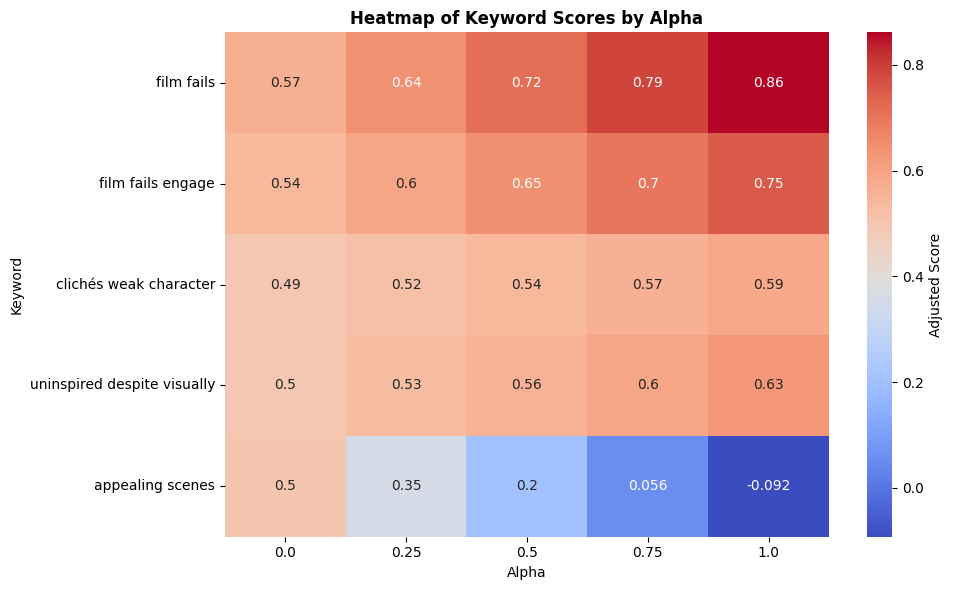

In [6]:
# Input review
pos_review = (
    "An emotionally rich and visually stunning film, blending heartfelt storytelling with top-tier performances. "
    "The direction is confident, and the musical score adds depth to every scene. "
    "It’s a rare example of cinematic craftsmanship that stays with you long after the credits roll. "
    "Though a few moments feel predictable, the overall experience is powerful and deeply satisfying."
)

neg_review = (
    "The film fails to engage on any emotional level, relying on clichés and weak character development. "
    "The pacing is sluggish, and the plot feels both disjointed and uninspired. "
    "Despite a few visually appealing scenes, the direction lacks vision and the performances are largely forgettable. "
    "It’s a frustrating and hollow experience that leaves little impact."
)

# Choose the review to analyze
# text = pos_review
text = neg_review 


# Instantiate base KeyBERT
base_model = KeyBERT(model="sentence-transformers/all-MiniLM-L6-v2")
base_keywords = base_model.extract_keywords(text, top_n=5, keyphrase_ngram_range=(1, 3))

# Define alpha values and initialize storage
alphas = [0.0, 0.25, 0.5, 0.75, 1.0]
sa_results = {}

# Load embedding model once
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Run sentiment-aware KeyBERT reranker for each alpha
print_doc = True  # Flag to control polarity print

for alpha in alphas:
    model = KeyBERTSentimentReranker(
        model=embedding_model,
        alpha=alpha,
        sentiment_model_name="cardiffnlp/twitter-roberta-base-sentiment",
        device="cpu"
    )
    keywords = model.extract_keywords(
        text,
        top_n=5,
        keyphrase_ngram_range=(1, 3),
        print_doc_polarity=print_doc
    )
    sa_results[alpha] = keywords
    print_doc = False  # Disable after first iteration

# Pretty print comparison
def print_sa_comparison(base_keywords, sa_results):
    print("Base KeyBERT (Top {}):".format(len(base_keywords)))
    print(f"{'Keyword':40s} {'Score':>10s}")
    print("-" * 52)
    for kw, score in base_keywords:
        print(f"{kw:40s} {score:10.4f}")

    for alpha in sorted(sa_results.keys()):
        print(f"\nSA-KeyBERT (alpha = {alpha:.2f}) (Top {len(sa_results[alpha])}):")
        print(f"{'Keyword':40s} {'Score':>10s} {'Polarity':>12s}")
        print("-" * 66)
        for kw, score, pol in sa_results[alpha]:
            print(f"{kw:40s} {score:10.4f} {pol:12.3f}")

# Show result table
print_sa_comparison(base_keywords, sa_results)

# Prepare heatmap of scores
labels = list(set(kw for kwlist in sa_results.values() for kw, _, _ in kwlist))
scores_by_alpha = {
    alpha: {kw: score for kw, score, _ in sa_results[alpha]} for alpha in alphas
}

heatmap_data = pd.DataFrame({
    label: [scores_by_alpha[alpha].get(label, 0) for alpha in alphas]
    for label in labels
}, index=alphas)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data.T, annot=True, cmap="coolwarm", cbar_kws={'label': 'Adjusted Score'})
plt.title("Heatmap of Keyword Scores by Alpha", fontweight='bold')
plt.xlabel("Alpha")
plt.ylabel("Keyword")
plt.tight_layout()
plt.show()